# <h1><center> Quantifying the World </center></h1>
##  <h2><center> Case Study 3 </center></h2> 
### <h3><center> Presented by: </center></h3> 
### Alexander Sepenu
### Nnenna Okpara
### Taifur Chowdhury
### Juan Edgar Nunez - Gonzalez

# Business Understanding

<b>Objective:</b>
The IT team have noticed a surge in spam emails that employees of the company have been receiving that spook them to open them allowing hackers gain access into enterprise network. Management has expressed concern about these inceidents and have tasked the data science to come up with a solution that will drive internal email policy to curb these vulnerablities.
The IT team have done a fabulous job at isolating these types of emails through thier firewall software. The Data Science team requested these emails to analyze. These came as ham and spam types of emails, out of which a model will be built to classify which are spams and not spam using <b>Naïve Bayes and Clustering methods</b> to create a filteration process that will guard off these types of intrusion and improve network security.

The model evaluation metrics will be analyzed to see which model classifers does better and use the insight gained from the evaluation to mitigate the potential of misclassifying senitive business emails as spam. 

In [1]:
#List of Packages used
import numpy as np
import sys
from os import listdir, getcwd, chdir
from os.path import isfile, join, dirname, realpath
import pandas as pd
import re
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
import tarfile
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import math
import random
import csv
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB as NB
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn import model_selection
from sklearn import svm
from nltk import word_tokenize
from sklearn.metrics import accuracy_score,roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import plot_confusion_matrix

# Model Preparation

We intend to build a supervised machine learning model and a unsupervised machine learning model. For our supervised model, we have built a **Naive Bayes Classifier** which is a classification model for spam detection. This modeling technique discriminates objects based on given features. It calculates probablity of an event occurring given the occurance of another event. The primary assumption is all the features are independent of each other. The model is known as posterior as it takes an initial "belief" and updates it using likelihood of the occurance of the event - multiplies initial belief probability with likelihood probablity. 

For our unsupervised model, we have built a clustering model - **Kmeans clustering** model. **Kmeans** model takes a group of similar data points to form clusters. The goal is to find the underlying pattern in the dataset. The model takes a **K value** which is the number of centroids needed for the dataset in order to form the clusters. Data then gets allocated to the nearest cluster while keeping the value of the centroid as low as possible. **Kmeans** refers to averaging of the data to find the centroid. 

For our supervised model, we will measure the output to evaluate the model performance in terms of Accuracy, F1-score, Precision, Recall, AUC metrics.

For our unsupervised model, we will measure the model performance in terms of Silhouette score and evaluate it with the Silhouette plot.

Source: https://towardsdatascience.com/naive-bayes-classifier-81d512f50a7c

Source: https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1

# Data Engineering

The dataset is alphanumeric with a target variable of interest specifying whether the email contains spam or does not contain spam. 

The main features are: 
* filename, 
* is_spam (Target), 
* in_reply, 
* subj_caps, 
* attachments, 
* body_lines

#### Percentages of Spam per Email Feature
Under the **EDA** process the team explores the relationship between these features and how the affect each other. From this it was discovered that the data set is imbalanced and predorminantly skewed to the right. A deep dive shows that **74.4%** are **Not Spam** whereas **25.6%** are **Spam**. A probe further shows that **66.5%** of spam are not found in **replies** sent whereas **33.5%** are found in them. Digging furter, **1.7%** of spams recorded are found in **subject**  compared to **98.3%** that are not found in subject lines in an email.A further look at the dataset, it was discovered  **91.9%** of the spam are not fund in emails that contain ** attachments** compared to **8.1%** that are.

#### Outliers
It was discovered during the **EDA** process that there are some outliers that need attention. The team then did feature by feature analysis to see what that was. During this phase of the discovery, it was discovered that **body Line** had a comparatively high value which makes it look like an outlier.  The team  **excluded** the **body line** column to measure the effects on the model without it. In the Naive Bayes classification the entire data was used for **model evaluation**.

#### One Hot Encoding
Since majority of the dataset are categorical and are binary, they were recoded into numeric values of 1's being Yeses(Y) and 0's being Nos(N) for a better model building.  

#### Corrleation Matrix
During the **EDA** process, it was discovered that **Subj_Caps** and **Attachments** are **Positively Correlated with with the target variable **Is_Spam** and are probable vectors for an email being **Spam** or **Not_Spam** where as **In_Reply** and **Body_Lines** are **Negatively Correlated** with the same.

A further look at the matrix shows that, **attachment** is **weakly correlated** with **in_reply, subj_caps** and **body_lines** which means that these spams **do not** come with attachments but rather as text in emails. 

Source:https://www.statology.org/how-to-read-a-correlation-matrix/

#### Target Variable
The email file was read in and all binary columns were recoded from categorical "Y" to 1 and "N" to 0

In [2]:
def get_cwd():
    try:
        chdir(dirname(realpath(__file__)))
    except:
        chdir('put your directory name here')

    active_dir = getcwd()
       
    return active_dir

def main():
    
    get_cwd()
    
    directories = [
            'easy_ham',
            'easy_ham_2',
            'hard_ham',
            'spam',
            'spam_2'
        ]
    
    res_frame = pd.DataFrame()
    
    # Added to generate a list of text strings
    text_list = []
    #####
        
    for d in directories:
        mypath = getcwd() + '/SpamAssassinMessages/' + d + '/'
        onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    
        try:
            onlyfiles.remove('.DS_Store')
        except:
            pass
        
        for file in onlyfiles:
            with open(mypath + file, encoding='latin1') as f:
                lines = f.readlines()
                f.close()
                
            in_reply_count = 0
            sub_line_all_caps = 0
            attachments = 0
            subject_line = []
            n_lines = 0
            blank_lines = []
            
            # Will be appended to as the email is "read in"
            temp_text_list = ''
            #####
            
            for line in lines:
               n_lines += 1
               if "Subject: Re: " in line:
                   in_reply_count += 1
               if "Subject: " in line:
                   s_line = line.strip().replace('Subject: ','')
                   s_line = ''.join(e for e in s_line if e.isalnum())
                   num_upper = sum(1 for c in s_line if c.isupper())
                   ttl_chars = len(s_line)
                   if num_upper == ttl_chars:
                       sub_line_all_caps += 1
                   subject_line.append(s_line)
               if "content-type: multipart" in line.lower():
                   attachments += 1
               if line == "\n":
                   blank_lines.append(n_lines)

               # Appends the current line to the existing string
               temp_text_list += ' ' + line
            
            # Formats the complete email string (removing new lines and whitespaces)
            temp_text_list = temp_text_list.replace('\n', ' ').replace('\r', '')
            temp_text_string = re.sub(' +', ' ', temp_text_list)   
            text_list.append(temp_text_string)
            #####
            
        
            temp_frame = pd.DataFrame({
                        'filename':file,
                        'is_spam':['Y' if 'spam' in d else 'N'],
                        'in_reply': ['Y' if in_reply_count > 0 else 'N'], 
                        'subj_caps': ['Y' if sub_line_all_caps > 0 else 'N'], 
                        'attachments': ['Y' if attachments > 0 else 'N'], 
                        'body_lines': [1 if len(blank_lines) == 0 else min(blank_lines)]
                        }, index=[0])
           
            res_frame = res_frame.append(temp_frame, ignore_index=True)
            
    res_frame.to_csv('email_df.csv', index=False)
    
    return res_frame, text_list # text_list is new

########################################
##### Main Function
########################################    

if __name__ == "__main__":
    res_frame, vocabs = main()
    pass

#### Checking for Missing values 
With not missing values in the columns we can proceed with our EDA

In [3]:
#checking the null values in the dataset
res_frame.isnull().sum()

filename       0
is_spam        0
in_reply       0
subj_caps      0
attachments    0
body_lines     0
dtype: int64

In [4]:
#Checking the shape of the dataset
res_frame.shape

(9353, 6)

In [5]:
# Looking at the head of the data
res_frame.head()

,filename,is_spam,in_reply,subj_caps,attachments,body_lines
0,2170.78c282a5e417d6d231dc75aa8588ebb7,N,N,N,N,24
1,0461.7609029b07acf65f40bd93882aa35887,N,N,N,N,51
2,00769.25bf9a767b5db0ed93f03c1637281663,N,Y,N,N,43
3,01074.8590d61ac0aeeadb58dc2f2ba776c406,N,N,N,N,51
4,02479.14365bcad3a60fcf24c5c1813f6291fb,N,Y,N,N,48


In [6]:
# Looking at data type of the data
# The dataset has 5 categorical and 1 numerical columns
res_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9353 entries, 0 to 9352
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   filename     9353 non-null   object
 1   is_spam      9353 non-null   object
 2   in_reply     9353 non-null   object
 3   subj_caps    9353 non-null   object
 4   attachments  9353 non-null   object
 5   body_lines   9353 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 438.5+ KB


In [7]:
# reading the email dataset and checking the headers
v = pd.read_csv('email_df.csv')
email_df.columns.tolist()

['filename', 'is_spam', 'in_reply', 'subj_caps', 'attachments', 'body_lines']

In [8]:
# recoding spam response to get a better view
cleanup = {"is_spam": {"Y": "Spam", "N": 'Not_Spam'}}
email_df = email_df.replace(cleanup)
email_df.head()

,filename,is_spam,in_reply,subj_caps,attachments,body_lines
0,2170.78c282a5e417d6d231dc75aa8588ebb7,Not_Spam,N,N,N,24
1,0461.7609029b07acf65f40bd93882aa35887,Not_Spam,N,N,N,51
2,00769.25bf9a767b5db0ed93f03c1637281663,Not_Spam,Y,N,N,43
3,01074.8590d61ac0aeeadb58dc2f2ba776c406,Not_Spam,N,N,N,51
4,02479.14365bcad3a60fcf24c5c1813f6291fb,Not_Spam,Y,N,N,48


In [9]:
# recoding all categorical variables to numeric
cleanup_nums = {"is_spam": {"Spam": 1, "Not_Spam": 0},
                "in_reply": {"Y": 1, "N": 0}, 
                "subj_caps": {"Y": 1, "N": 0},
                "attachments": {"Y": 1, "N": 0}}
email_num = email_df.replace(cleanup_nums)
email_num.head()

,filename,is_spam,in_reply,subj_caps,attachments,body_lines
0,2170.78c282a5e417d6d231dc75aa8588ebb7,0,0,0,0,24
1,0461.7609029b07acf65f40bd93882aa35887,0,0,0,0,51
2,00769.25bf9a767b5db0ed93f03c1637281663,0,1,0,0,43
3,01074.8590d61ac0aeeadb58dc2f2ba776c406,0,0,0,0,51
4,02479.14365bcad3a60fcf24c5c1813f6291fb,0,1,0,0,48


In [10]:
# recoding categorical variable to numeric for naive bayes classification
cleanup_num = {"is_spam": {"Spam": 1, "Not_Spam": 0},
              "in_reply": {"Y": 1, "N": 0}, 
              "subj_caps": {"Y": 1, "N": 0},
              "attachments": {"Y": 1, "N": 0}}
email_df1 = email_df.replace(cleanup_num)
email_df1.head()

,filename,is_spam,in_reply,subj_caps,attachments,body_lines
0,2170.78c282a5e417d6d231dc75aa8588ebb7,0,0,0,0,24
1,0461.7609029b07acf65f40bd93882aa35887,0,0,0,0,51
2,00769.25bf9a767b5db0ed93f03c1637281663,0,1,0,0,43
3,01074.8590d61ac0aeeadb58dc2f2ba776c406,0,0,0,0,51
4,02479.14365bcad3a60fcf24c5c1813f6291fb,0,1,0,0,48


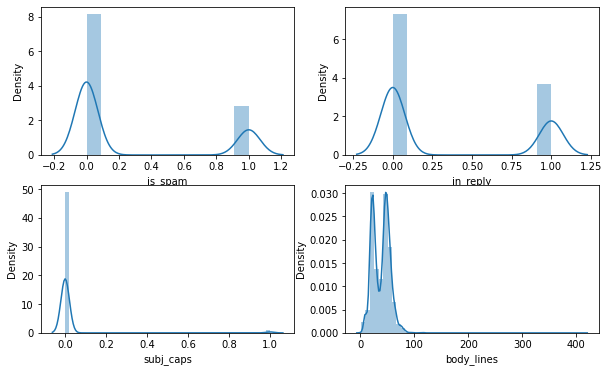

In [11]:
# Distribution Plot of data set 
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(10,6))
plt.subplot(2,2,1)
sns.distplot(email_num['is_spam'])
plt.subplot(2,2,2)
sns.distplot(email_num['in_reply'])
plt.subplot(2,2,3)
sns.distplot(email_num['subj_caps'])
plt.subplot(2,2,4)
sns.distplot(email_num['body_lines'])
plt.show()

Not_Spam    74.4%
Spam        25.6%
Name: is_spam, dtype: object

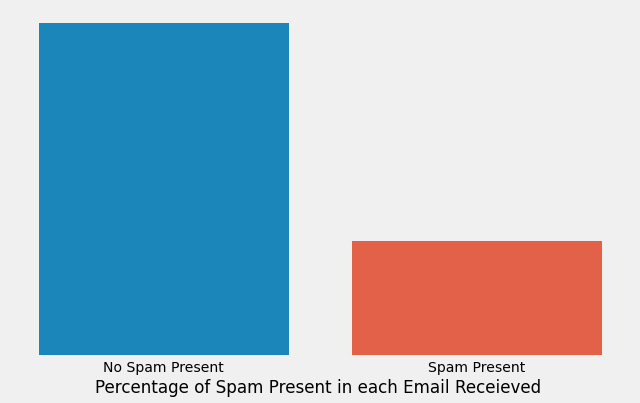

In [12]:
# # Percentage of spam found in each email received
%matplotlib inline
warnings.filterwarnings("ignore")
spam = email_df['is_spam']
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,6))
sns.countplot(spam)
plt.xticks([1,0],['Spam Present','No Spam Present'])
plt.xlabel('Percentage of Spam Present in each Email Receieved ')
plt.ylabel('')
plt.yticks([])
email_df.is_spam.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'


N    66.5%
Y    33.5%
Name: in_reply, dtype: object

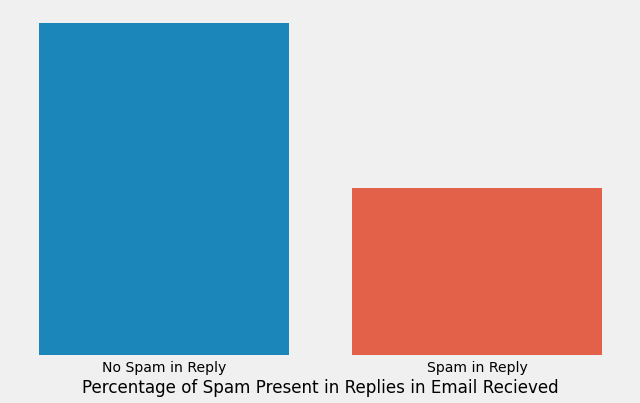

In [13]:
# Percentage of spam found in replies in emails received
%matplotlib inline
warnings.filterwarnings("ignore")
reply = email_df['in_reply']
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,6))
sns.countplot(reply)
plt.xticks([1,0],['Spam in Reply','No Spam in Reply'])
plt.xlabel('Percentage of Spam Present in Replies in Email Recieved')
plt.xticks(rotation=0)
plt.ylabel('')
plt.yticks([])
email_df.in_reply.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

N    98.3%
Y     1.7%
Name: subj_caps, dtype: object

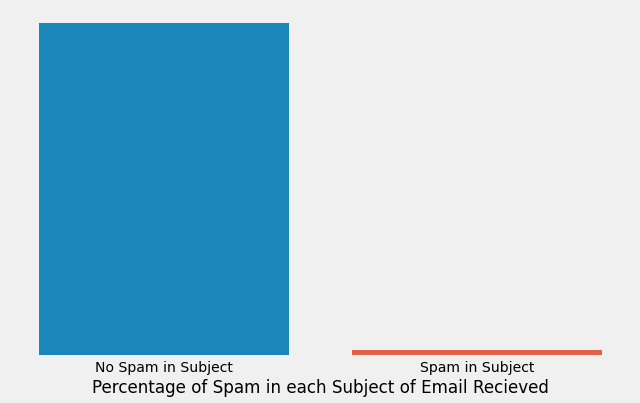

In [14]:
# Percentage of spam found in subject line capitalized in emails received
%matplotlib inline
warnings.filterwarnings("ignore")
subject = email_df['subj_caps']
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,6))
sns.countplot(subject)
plt.xticks([1,0],['Spam in Subject','No Spam in Subject'])
plt.xlabel('Percentage of Spam in each Subject of Email Recieved')
plt.xticks(rotation=0)
plt.ylabel('')
plt.yticks([])
email_df.subj_caps.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

N    91.9%
Y     8.1%
Name: attachments, dtype: object

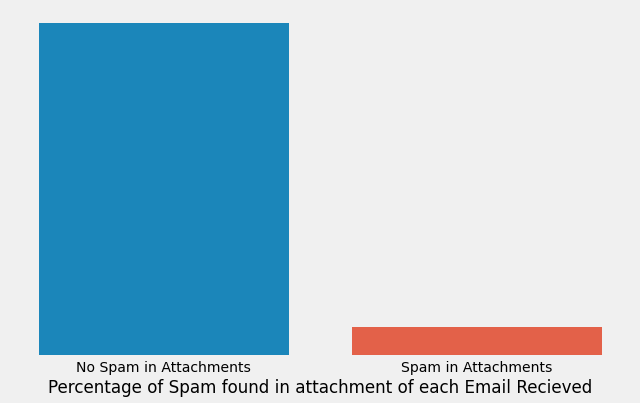

In [15]:
# Percentage of spam found in attachements in emails received
%matplotlib inline
warnings.filterwarnings("ignore")
attach = email_df['attachments']
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,6))
sns.countplot(attach)
plt.xticks([1,0],['Spam in Attachments','No Spam in Attachments'])
plt.xlabel('Percentage of Spam found in attachment of each Email Recieved')
plt.ylabel('')
plt.yticks([])
email_df.attachments.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

### Detecting outliers


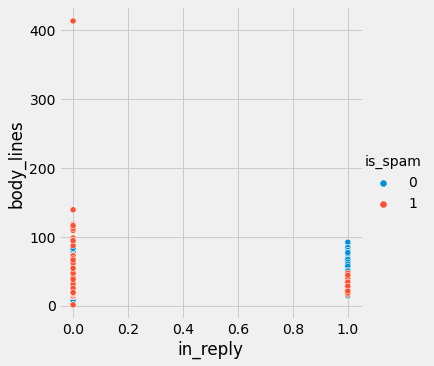

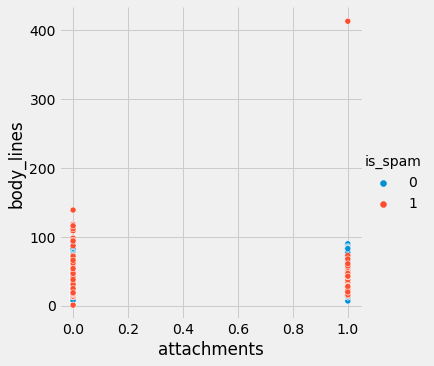

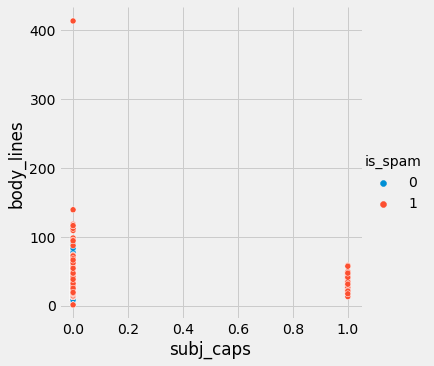

In [16]:
#Finding outliers in data set from each column
sns.relplot(x="in_reply", y="body_lines", hue="is_spam", data= email_num);
sns.relplot(x="attachments", y="body_lines", hue="is_spam", data= email_num);
sns.relplot(x="subj_caps", y="body_lines", hue="is_spam", data= email_num);

<AxesSubplot:ylabel='body_lines'>

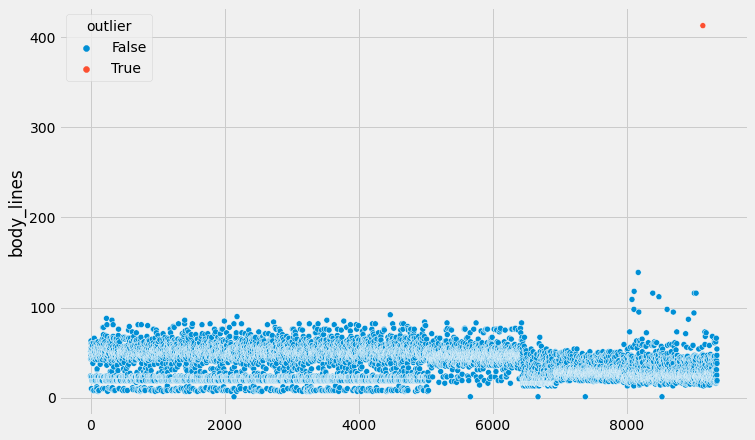

In [17]:
# Scatter Plot confirming if indeed outlier is in body_lines comapred to other features in dataset
plt.figure(figsize=(11,7))
email_num['outlier'] = (email_num['body_lines'] >= 140)
sns.scatterplot(data=email_num, y='body_lines', x=range(0,9353), hue='outlier')

In [18]:
# dropping outlier and column not needed to do further analysis
email_num = email_num.drop(['outlier'], axis=1)
email_num = email_num.drop(['filename'], axis=1)
email_num = email_num[(email_num['body_lines'] >= 1) & (email_num['body_lines'] < 140)] # new dataframe for further analysis


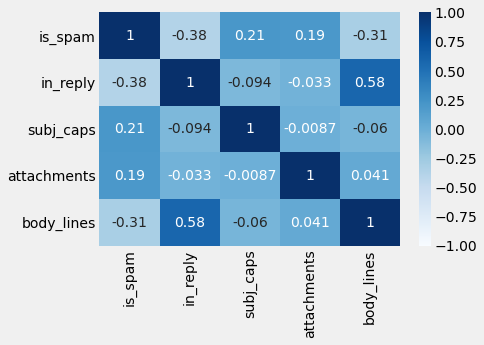

In [19]:
# Finding corrlation among the features to find their relationship
corr = email_num.corr()
sns.heatmap(corr, cmap="Blues",vmin=-1, vmax=1, annot=True)

plt.show()

# Model Building and Evaluation

For our **Naive Bayes Classifier** model, we have split the dataframe using 70/30 method - 70% train data and 30% test. Using the cross-validation method, the model produced accuracy score of 99%. For `Not Spam` prediction, the model produced 99% accuracy, 99% recall, and 99% f1-score. For `Spam` prediction, the model produced 98% accuracy, 96% recall, and 97% f1-score. These scores indicate our classification model performed very well as it was able to classify objects accurately. The ROC curve provides a visual representation of model performance. It validates the 99% accuracy score and also tells us how well the model identifies the seperation between classes.

The model's marging of error is 0.0050, which is a clear indication that the model, when implemente in the organization, is more than likely to clasify spam as Spam. This reduces the potential for information loss due to missclassification of legitimate emails as Spam.

Source: https://www.displayr.com/what-is-a-roc-curve-how-to-interpret-it/

### Naive Bayes Classifier

In [39]:
#Naive Bayes Classifier
#removes stopwords from text in vocabs
from sklearn.naive_bayes import MultinomialNB
vectorizer = CountVectorizer(analyzer='word', stop_words='english', ngram_range=(2,2)) 
X = vectorizer.fit_transform(vocabs)
y = email_df['is_spam'].values

#train test split 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

NB = MultinomialNB()
NB.fit(X_train, y_train)
y_pred = NB.predict(X_test)
#print('Naive Bayes classifier Accuracy on test set= {:.2f}'.format(accuracy_score(NB.predict(X_test), y_test)))

In [22]:
# Testing NB Classifier on unseen data
y_pred = NB.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Not_Spam       0.99      0.99      0.99      2095
        Spam       0.98      0.96      0.97       711

    accuracy                           0.99      2806
   macro avg       0.98      0.98      0.98      2806
weighted avg       0.98      0.99      0.99      2806



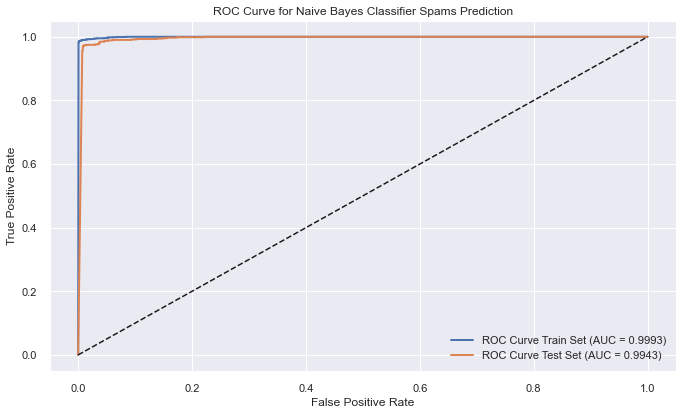

ROC AUC for Train Set : 0.9993
ROC AUC for Test Set : 0.9943
Model's Margin of Error for Train-Test Set: 0.0050


In [101]:
# plot ROC Curve on train/test set

from sklearn.metrics import roc_curve
vectorizer = CountVectorizer(analyzer='word', stop_words='english', ngram_range=(2,2)) 
X1 = vectorizer.fit_transform(vocabs)
y1 = email_df1['is_spam'].values 
X2 = vectorizer.fit_transform(vocabs)
y2 = email_df1['is_spam'].values

#train test split 70/30
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.30, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.30, random_state=42)

NB = MultinomialNB()
NB.fit(X1_train, y1_train)
NB.fit(X2_train, y2_train)

# predict probabilities
y1_pred = NB.predict_proba(X1_train)[:,1]
y2_pred = NB.predict_proba(X2_test)[:,1]

fpr, tpr, threshold1 = roc_curve(y1_train, y1_pred, pos_label=1)
fpr1, tpr1, threshold2 = roc_curve(y2_test, y2_pred, pos_label=1)

roc_auc = auc(fpr, tpr)
roc_auc1 = auc(fpr1, tpr1)

plt.figure(figsize=(10,6))

plt.plot(fpr, tpr, label='ROC Curve Train Set (AUC = %0.4f)' % (roc_auc),linewidth=2)

plt.plot(fpr1, tpr1, label='ROC Curve Test Set (AUC = %0.4f)' % (roc_auc1),linewidth=2)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12

plt.title('ROC Curve for Naive Bayes Classifier Spams Prediction')

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')

plt.legend(loc="lower right")

plt.show()

ROC_AUC1 = roc_auc_score(y1_train, y1_pred)
ROC_AUC2 = roc_auc_score(y2_test, y2_pred)
print('ROC AUC for Train Set : {:.4f}'.format(ROC_AUC1))
print('ROC AUC for Test Set : {:.4f}'.format(ROC_AUC2))
print('Model\'s Margin of Error for Train-Test Set: {:.4f}'.format(ROC_AUC1 - ROC_AUC2))

### K-means Clustering 

For our unsupervised algorithm, we picked **K-means** to build our model. We transformed the text in the body of the emails into feature vectors that we then used to fit into kmeans model. We then proceeded to identify that there are three clusters in the data matrix. Using the clusters, we measured the performance of our model using Silhouette Score. The model scored 0.064 which indicates that the clusters have insignificant distances between data points. Also, we can vidually notice that the clusters are occupying the same vector. 

The Silhouette Score measures the quality of clusters that are created using **K-means** algorithm. It measures the distance that points in a cluster are from points in a neighboring cluster. Thus it gives a measure of the performance of the our clustering algorithm. 

The metrics ranges from -1 to 1:

1 meaning the clusters are visually distinguishable from one another.

0 meaning the distance between clusters is insignificant.

-1 means clusters are sharing the same vector space. 



Source: https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c 

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_vectors = TfidfVectorizer()
email_vectors = tf_vectors.fit_transform(vocabs)

In [91]:
import seaborn as sns
sns.set()
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

kmeans = KMeans(3)
kmeans.fit(email_vectors)

KMeans(n_clusters=3)

In [92]:
identified_clusters = kmeans.fit_predict(email_vectors)
identified_clusters

array([1, 1, 1, ..., 1, 0, 0], dtype=int32)

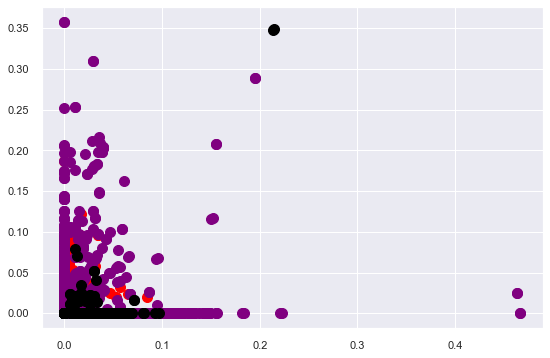

In [99]:
#Model Cluster Plot

plt.scatter(email_vectors.toarray()[identified_clusters==0,0], email_vectors.toarray()[identified_clusters==0,1], s=100, marker='o', color='red')
plt.scatter(email_vectors.toarray()[identified_clusters==1,0], email_vectors.toarray()[identified_clusters==1,1], s=100, marker='o', color='purple')
plt.scatter(email_vectors.toarray()[identified_clusters==2,0], email_vectors.toarray()[identified_clusters==2,1], s=100, marker='o', color='black')

plt.show()

In [93]:
score = silhouette_score(email_vectors, kmeans.labels_, metric='euclidean')
print('Silhouetter Score: %.3f' % score)

Silhouetter Score: 0.064


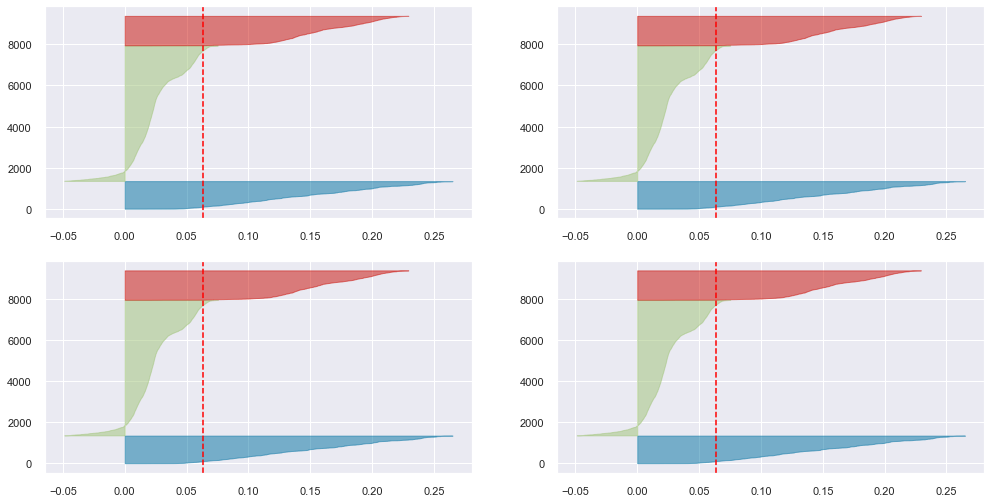

In [94]:
# Visual Representation of Cluster Performance
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(email_vectors)

Source: https://dzone.com/articles/kmeans-silhouette-score-explained-with-python-exam

# Conclusion

The data consists of emails provided in five folders (easy ham, easy_ham, hard ham, spam, and spam_2. The emails were parsed using regular text parser and html parser based on the email type to construct a dataset. Data cleaning was used to remove html tags, NaN, and unwanted characters. Natural Language Processing (NLP) was used to parse the emails. It was used to identify the text in the email. Naïve Bayes was used to classify the dataset.

Our supervised model, **Naive Bayes Classifier** had performed well given the high accuracy score of 99%. Our unsupervised model identified poor seperation between our data clusters with a score of 0.064. Going forward, we could explore other methods to evaluate our unsupervised model like **Rand Index**, **Mutual Information**, and **Davies-Bouldin Index**. 

Based on our findings, we recommend the use of **Naive Bayes Classifier** for this imbalanced dataset due to its outstanding performance. For unsupervised algorithm, we recommend other methods **DBSCAN**, **Agglomerative**, **PCA**, and **KNN**.

Source: https://towardsdatascience.com/performance-metrics-in-machine-learning-part-3-clustering-d69550662dc6

Source: https://www.javatpoint.com/unsupervised-machine-learning

In [2]:
import h2o
from h2o.estimators import H2OKMeansEstimator
h2o.init()

email = h2o.import_file("C:/Users/korku/Documents/MY SMU COURSES/Semester 2/Spring 2022/Quantifying the World/Case Study 3/email_df.csv")

# Set the predictors:
predictors = ['filename', 'is_spam', 'in_reply', 'subj_caps', 'attachments', 'body_lines']

# Split the dataset into a train and valid set:
train, valid = email.split_frame(ratios=[.7], seed=1234)

# Build and train the model:
email_kmeans = H2OKMeansEstimator(k=10,
                                 estimate_k=True,
                                 standardize=False,
                                 seed=1234)
email_kmeans.train(x=predictors,
                  training_frame=train,
                  validation_frame=valid)

# Eval performance:
perf = email_kmeans.model_performance()

#  Generate predictions on a validation set (if necessary):
pred = email_kmeans.predict(valid)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM AdoptOpenJDK (build 11.0.9+11, mixed mode)
  Starting server from C:\Users\korku\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\korku\AppData\Local\Temp\tmpr0gdq7ue
  JVM stdout: C:\Users\korku\AppData\Local\Temp\tmpr0gdq7ue\h2o_korku_started_from_python.out
  JVM stderr: C:\Users\korku\AppData\Local\Temp\tmpr0gdq7ue\h2o_korku_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.2
H2O_cluster_version_age:,18 days
H2O_cluster_name:,H2O_from_python_korku_f02kk8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.973 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
kmeans Model Build progress: |

C:\Users\korku\anaconda3\lib\site-packages\h2o\estimators\estimator_base.py:208: RuntimeWarning: Dropping bad and constant columns: [filename]
  warnings.warn(mesg["message"], RuntimeWarning)


███████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%
